# Milan Kovacs
## 21308128

Task: 
Repeat the experiment in Lab5 - Regression and Dimensionality Reduction.ipynb with insurance.csv and draw conclusions from the results you observe in a markdown cell. Add a third regression algorithm of your choice. Describe how it compares to Random Forest and Linear regression in a markdown cell (max 250 words in a markdown cell).

In [87]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import FeatureAgglomeration
from sklearn.compose import (ColumnTransformer, TransformedTargetRegressor)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler, RobustScaler, OneHotEncoder)
from sklearn.random_projection import GaussianRandomProjection
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## EDA

In [88]:
df = pd.read_csv('insurance.csv')
df.head()

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075


In [89]:
df.tail()

,age,gender,bmi,children,smoker,region,insurance_cost
1333,64,female,31.825,2,no,northeast,16069.08475
1334,64,female,26.885,0,yes,northwest,29330.98315
1335,64,male,26.410,0,no,northeast,14394.55790
1336,64,male,36.960,2,yes,southeast,49577.66240
1337,64,male,23.760,0,yes,southeast,26926.51440


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             1338 non-null   int64  
 1   gender          1338 non-null   object 
 2   bmi             1338 non-null   float64
 3   children        1338 non-null   int64  
 4   smoker          1338 non-null   object 
 5   region          1338 non-null   object 
 6   insurance_cost  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [91]:
df['age'].value_counts()

age
18    69
19    68
20    29
51    29
45    29
46    29
47    29
48    29
50    29
52    29
28    28
54    28
21    28
27    28
26    28
49    28
25    28
24    28
23    28
22    28
53    28
42    27
44    27
43    27
41    27
40    27
31    27
30    27
29    27
56    26
34    26
33    26
32    26
57    26
55    26
35    25
59    25
58    25
36    25
39    25
38    25
37    25
60    23
61    23
62    23
63    23
64    22
Name: count, dtype: int64

In [92]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

We have no missing values in the dataset.


In [93]:
df.describe()

,age,bmi,children,insurance_cost
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


From the describe of the dataset, we can see some interesting things that might be worth exploring further:
- The age of the people in the dataset ranges from 18 to 64, see how many people are in each age group.
- The number of children ranges from 0 to 5, but the Standard Deviation is 1.2, which means that the majority of people have 0 or 1 children.

In [94]:
df[df.children == 0]

,age,gender,bmi,children,smoker,region,insurance_cost
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
4,18,female,35.625,0,no,northeast,2211.13075
6,18,female,30.115,0,no,northeast,21344.84670
7,18,male,23.750,0,no,northeast,1705.62450
...,...,...,...,...,...,...,...
1331,64,female,39.700,0,no,southwest,14319.03100
1332,64,female,35.970,0,no,southeast,14313.84630
1334,64,female,26.885,0,yes,northwest,29330.98315
1335,64,male,26.410,0,no,northeast,14394.55790


In [95]:
df[df.children == 5]

,age,gender,bmi,children,smoker,region,insurance_cost
71,19,female,28.600,5,no,southwest,4687.79700
141,20,female,37.000,5,no,southwest,4830.63000
155,20,male,30.115,5,no,northeast,4915.05985
284,25,male,23.900,5,no,southwest,5080.09600
386,28,male,24.300,5,no,southwest,5615.36900
447,31,male,28.500,5,no,northeast,6799.45800
506,33,male,42.400,5,no,southwest,6666.24300
513,33,male,33.440,5,no,southeast,6653.78860
663,39,female,24.225,5,no,northwest,8965.79575
664,39,female,34.320,5,no,southeast,8596.82780


There is 574 people with 0 children and 18 people with 5 children. Seems to be left skewed.

In [96]:
df[df.age == 64]

,age,gender,bmi,children,smoker,region,insurance_cost
1316,64,male,24.700,1,no,northwest,30166.61817
1317,64,female,31.300,2,yes,southwest,47291.05500
1318,64,female,39.330,0,no,northeast,14901.51670
1319,64,female,33.800,1,yes,southwest,47928.03000
1320,64,male,34.500,0,no,southwest,13822.80300
1321,64,female,30.115,3,no,northwest,16455.70785
1322,64,male,25.600,2,no,southwest,14988.43200
1323,64,female,32.965,0,no,northwest,14692.66935
1324,64,male,39.160,1,no,southeast,14418.28040
1325,64,male,33.880,0,yes,southeast,46889.26120


There are 22 people with the age of 64. Probably a good idea to keep this in the dataset.

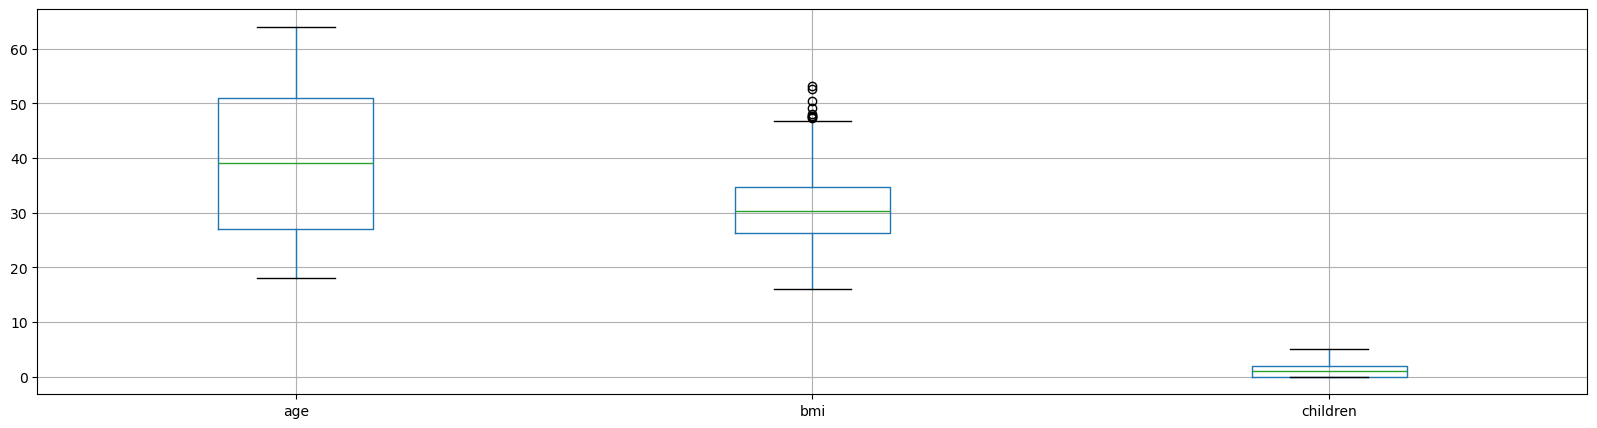

In [97]:
df.drop('insurance_cost', axis=1).boxplot(figsize=(20, 5))
plt.show()

BMI seems to have some outliers. We can see that the majority of the people have a BMI between 25 and 35, but there are some people with a BMI of over 50. 

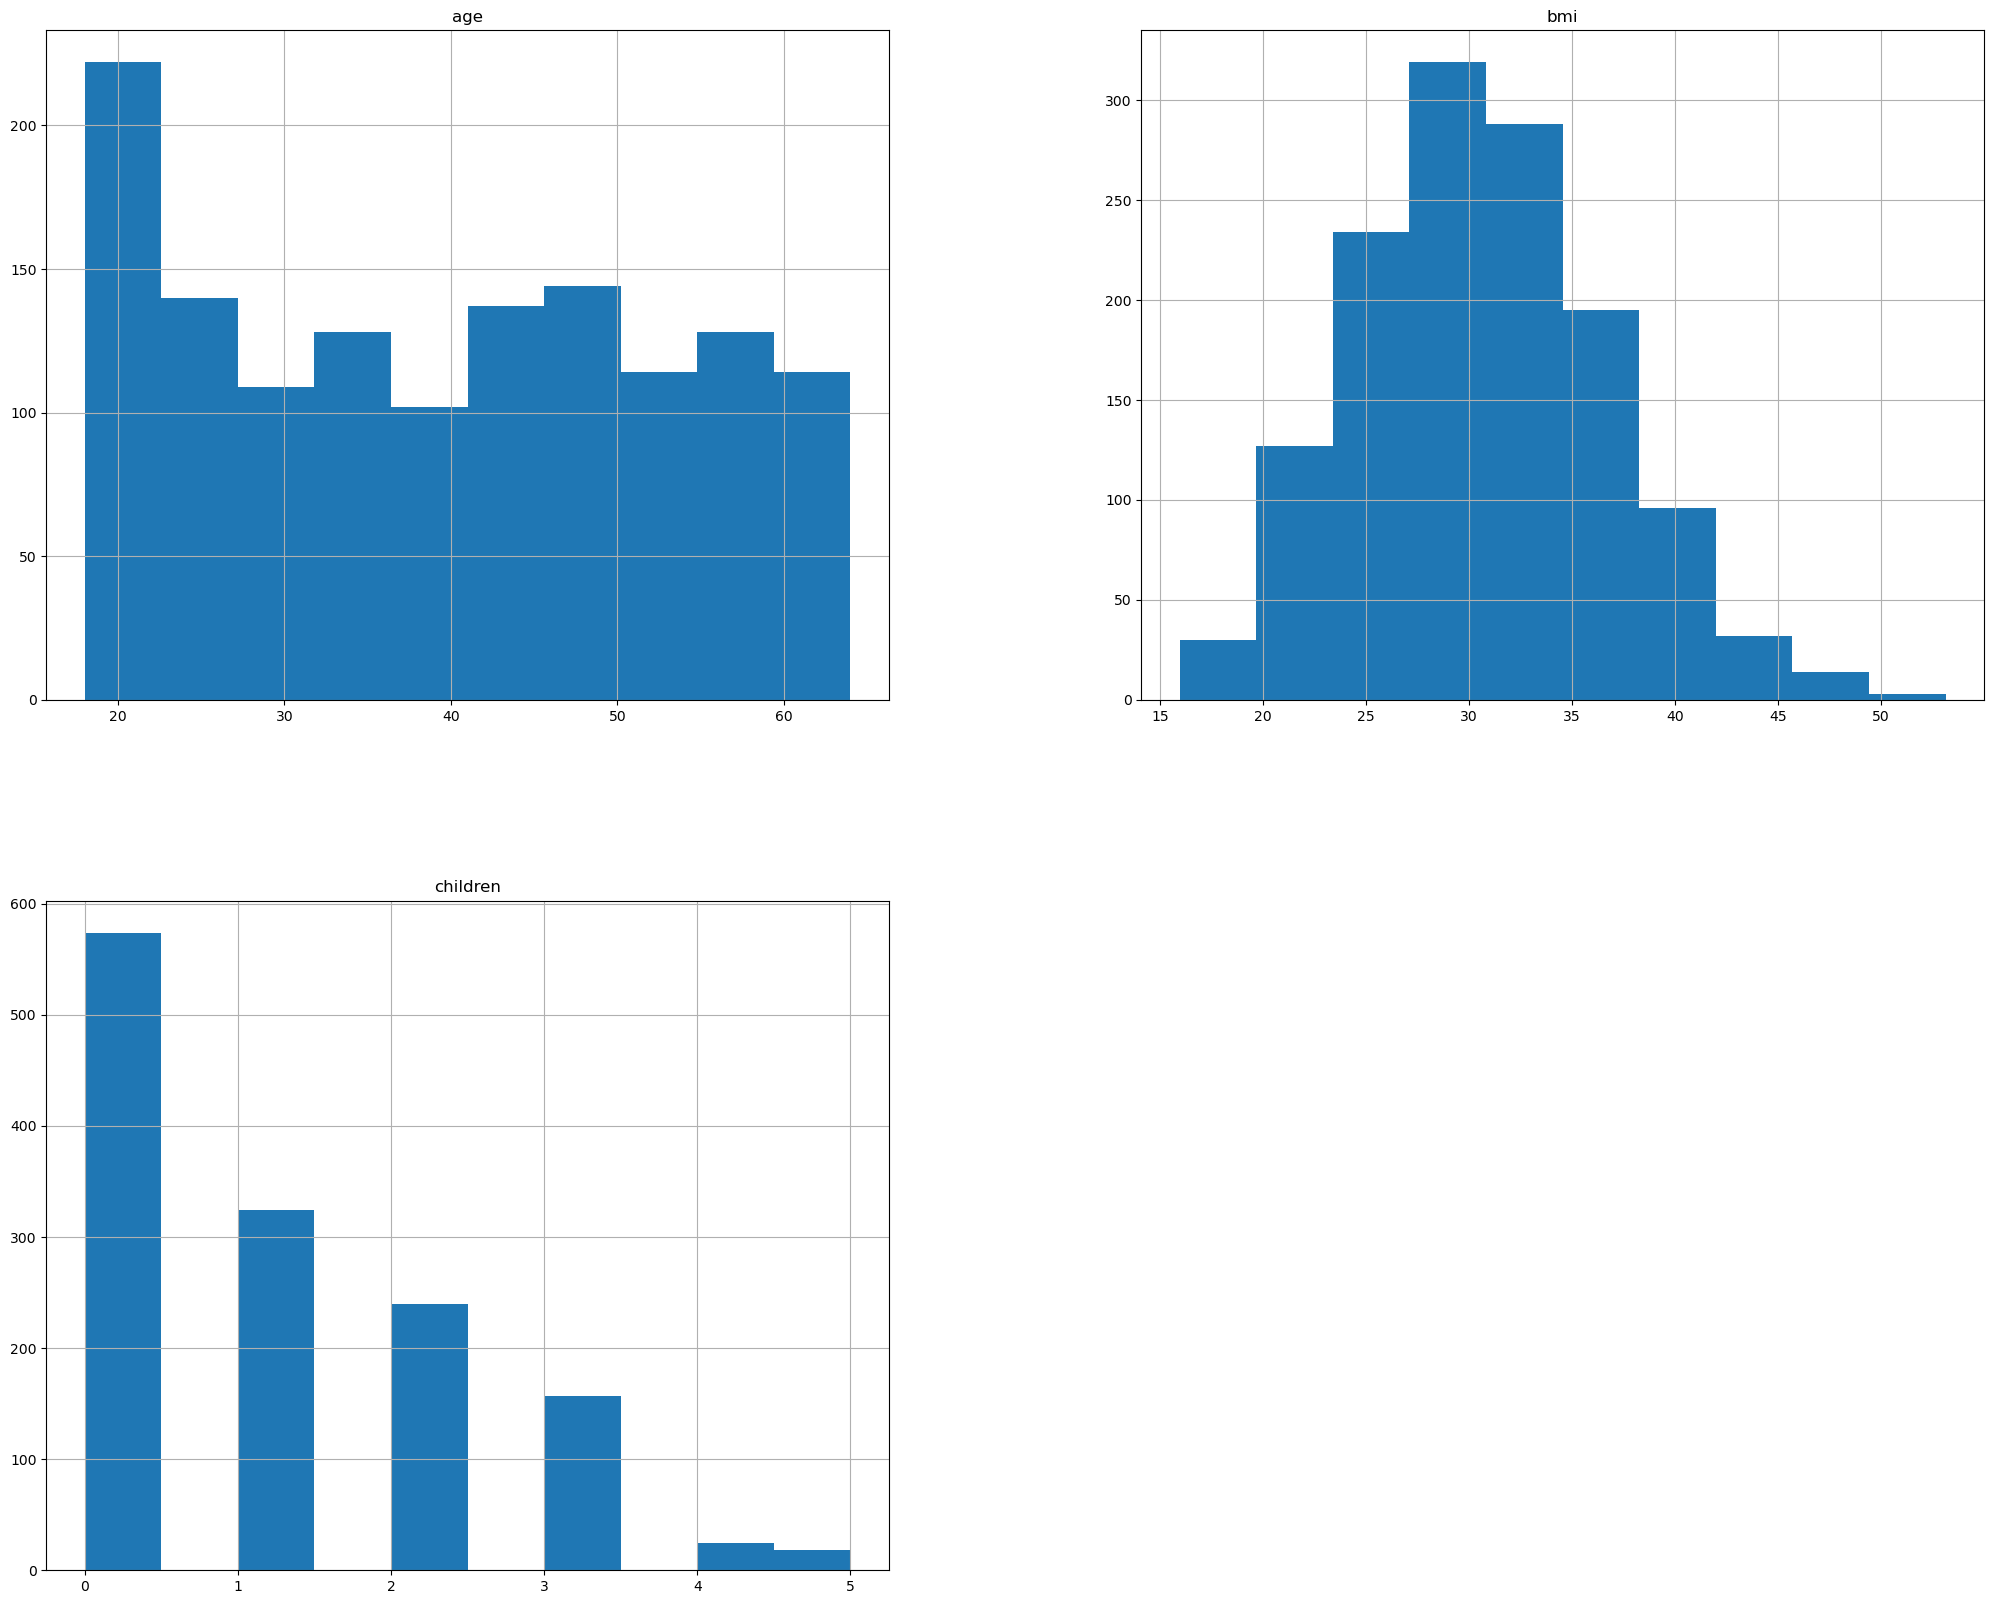

In [98]:
df.drop('insurance_cost', axis=1).hist(bins=10, figsize=(25, 20))
plt.show()

We can see that the age and the number of children are right skewed, while the BMI is close to a normal distribution.

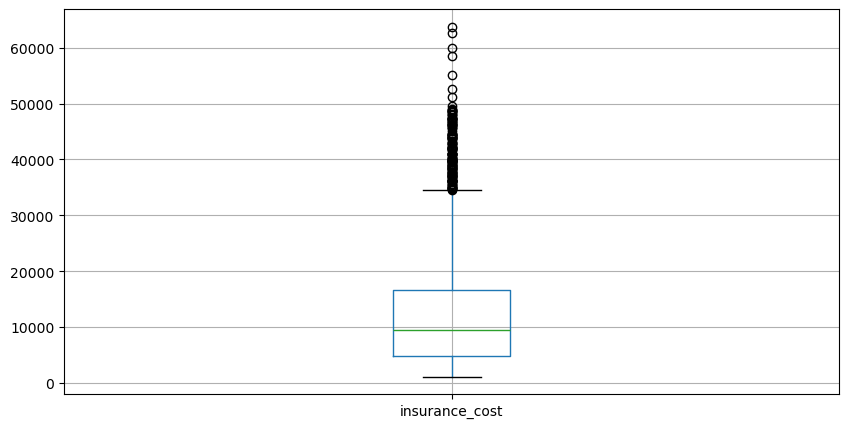

In [99]:
df.boxplot(column='insurance_cost', figsize=(10, 5))
plt.show()

The insurance costs has a lot of outliers. We can see that the majority of the people have an insurance cost of less than 10,000, but there are some people with an insurance cost of over 35,000.

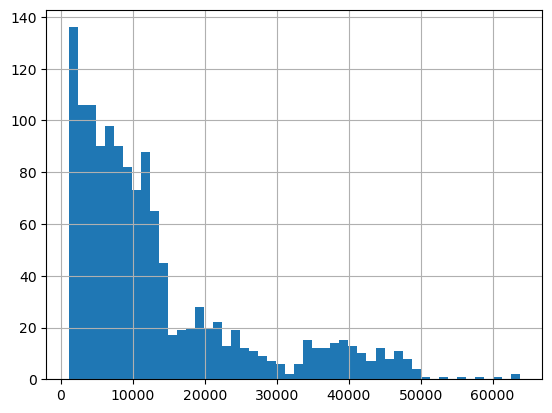

In [100]:
df['insurance_cost'].hist(bins=50)
plt.show()

The insurance cost is right skewed. We will normalize this column in the preprocessing step.

## Data Preparation

In [101]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1)

In [102]:
preprocess_pipeline = ColumnTransformer(
    transformers=[
        ("no_outliers", StandardScaler(), ['age', 'children']),
        ("categorical", OneHotEncoder(drop='first', sparse_output=False), ['smoker', 'region', 'gender'])
    ],
    remainder=RobustScaler()  # bmi
).set_output(transform="pandas")


In [103]:
X_transformed = preprocess_pipeline.fit_transform(X);

In [104]:
X_transformed.head()

,no_outliers__age,no_outliers__children,categorical__smoker_yes,categorical__region_northwest,categorical__region_southeast,categorical__region_southwest,categorical__gender_male,remainder__bmi
0,-1.509965,-0.078767,0.0,0.0,1.0,0.0,1.0,0.401310
1,-1.509965,-0.908614,0.0,0.0,1.0,0.0,1.0,0.440607
2,-1.509965,-0.908614,0.0,0.0,0.0,0.0,0.0,-0.486454
3,-1.509965,0.751079,0.0,0.0,0.0,0.0,0.0,0.984221
4,-1.509965,-0.908614,0.0,0.0,0.0,0.0,0.0,0.622209


In [105]:
X_transformed.tail()

,no_outliers__age,no_outliers__children,categorical__smoker_yes,categorical__region_northwest,categorical__region_southeast,categorical__region_southwest,categorical__gender_male,remainder__bmi
1333,1.765289,0.751079,0.0,0.0,0.0,0.0,0.0,0.169693
1334,1.765289,-0.908614,1.0,1.0,0.0,0.0,0.0,-0.418577
1335,1.765289,-0.908614,0.0,0.0,0.0,0.0,1.0,-0.475141
1336,1.765289,0.751079,1.0,0.0,1.0,0.0,1.0,0.781185
1337,1.765289,-0.908614,1.0,0.0,1.0,0.0,1.0,-0.790712


In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Model Training

### Random Forest

In [107]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor=RandomForestRegressor(n_estimators=10),
                           func=np.log,
                           inverse_func=np.exp)
                        )
                       ]
                )

In [108]:
N_FEATURES_OPTIONS = [2, 6, 8]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.861:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear')), 'reduce_dim__n_features_to_select': 6, 'ttr__regressor__max_depth': 4}


### Linear Regression

In [109]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor=LinearRegression(),
                           func=np.log,
                           inverse_func=np.exp)
                        )
                       ]
                )

In [110]:
N_FEATURES_OPTIONS = [2, 6, 8]
FIT_INTERCEPT_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.530:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression()), 'reduce_dim__n_features_to_select': 6, 'ttr__regressor__fit_intercept': True}


### Support Vector Regression

In [111]:
# Support Vector Regression
from sklearn.svm import SVR

pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor=SVR(),
                           func=np.log,
                           inverse_func=np.exp)
                        )
                       ]
                )

In [112]:
N_FEATURES_OPTIONS = [2, 6, 8]
KERNEL_OPTIONS = ['linear', 'poly', 'rbf', 'sigmoid']

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__kernel': KERNEL_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__kernel': KERNEL_OPTIONS
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

SVR_best_params = search.best_params_
SVR_best_model = search.best_estimator_

Best CV score = 0.824:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear')), 'reduce_dim__n_features_to_select': 6, 'ttr__regressor__kernel': 'rbf'}


### Compare the three models

In [71]:
def evaluate_model(X_test, y_test, model):
    _predicted_values = model.predict(X_test)

    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)

    return _mse, _mae, _r2

In [72]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
SVR_mse, SVR_mae, SVR_r2 = evaluate_model(X_test, y_test, SVR_best_model)

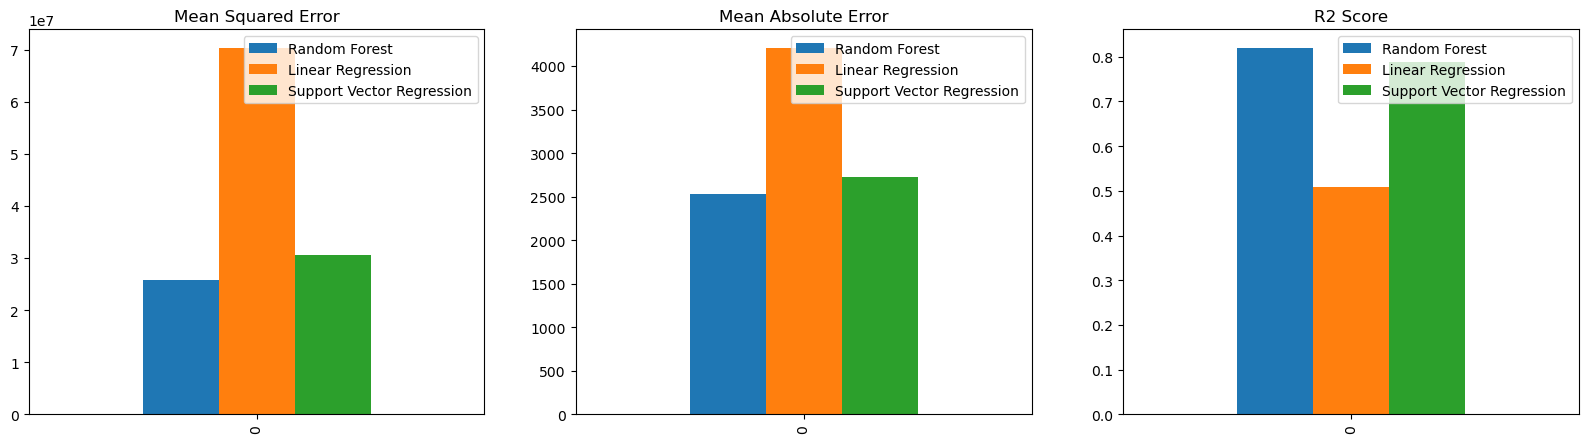

In [73]:
df_mse = pd.DataFrame(
    {'Random Forest': [RF_mse], 'Linear Regression': [LR_mse], 'Support Vector Regression': [SVR_mse]})
df_mae = pd.DataFrame(
    {'Random Forest': [RF_mae], 'Linear Regression': [LR_mae], 'Support Vector Regression': [SVR_mae]})
df_r2 = pd.DataFrame({'Random Forest': [RF_r2], 'Linear Regression': [LR_r2], 'Support Vector Regression': [SVR_r2]})

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

df_mse.plot(kind='bar', ax=ax[0], title='Mean Squared Error')
df_mae.plot(kind='bar', ax=ax[1], title='Mean Absolute Error')
df_r2.plot(kind='bar', ax=ax[2], title='R2 Score')

plt.show()

### Evaluation

Some explanation about the models:
- Random Forest is a classification algorithm based on many decision trees trained on subsets of the data. Then each tree makes a vote on the classification.
- Linear Regression is a regression algorithm that calculates the probability that a given inpt belongs to a certain category.
- Support Vector Machine tries to find the optimal hyperplane that best separates the classes in the feature space. 

### Result from the diagram

In the Mean Squared Error (MSE) Linear Regression performs worse. It has the highest rate of error between the actual and predicted classifications. The best performing is Random Forests with roughly 28% and a little behind SVM with around 31%. 

Mean Absolute Error (MAE) is the average of the absolute differences between the actual and predicted values. Similarly Linear Regression performed worst, by incorrectly predicting on average by 4,000, while Random Forest on Average is off by ~2,500. SVM is a little behind by ~2,700.

R2 Score is the proportion of varience in the dependent variable that is predictable from the independent variable. In this case the higher the better. Random Forest is best performing with little over 0.8 and little behind it is SVM. The worst performing is Linear Regression, meaning it is not able to predict the dependent variable.

Overall, Random Forest is the best performing model and slightly worse is SVM. 

## Train a final model

Add two dimensionality-reduction methods which are not used in CS5062 - Lab5 - Regression and Dimensionality Reduction.ipynb to the training pipelines for insurance.csv. Aim at dimensionality reduction techniques that are sufficiently different from the ones used in the example notebook. Draw conclusions from the results you observe in a markdown cell (max 250 words in a markdown cell).


In [113]:
from sklearn.pipeline import make_pipeline


# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

In [114]:
import pickle

filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

## Dimensionality Reduction

The two dimension reductions I have chosen to go with is:
- Gaussian Random Projection
- Feature Agglomeration

## Random Forest

In [74]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor=RandomForestRegressor(n_estimators=10),
                           func=np.log,
                           inverse_func=np.exp)
                        )
                       ]
                )

In [75]:
from sklearn.random_projection import GaussianRandomProjection
from sklearn.cluster import FeatureAgglomeration

N_FEATURES_OPTIONS = [2, 6, 8]
BATCH_SIZE_OPTIONS = [5, 10, 20]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'reduce_dim__whiten': [True, False]
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [GaussianRandomProjection()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'reduce_dim__eps': [0.1, 0.2, 0.3]
    },
    {
        'reduce_dim': [FeatureAgglomeration()],
        'reduce_dim__n_clusters': N_FEATURES_OPTIONS,
        'reduce_dim__linkage': ['ward', 'complete', 'average']
    }

]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

reduced_RF_best_params = search.best_params_
reduced_RF_best_model = search.best_estimator_

Best CV score = 0.862:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear')), 'reduce_dim__n_features_to_select': 8, 'ttr__regressor__max_depth': 4}


In [76]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor=LinearRegression(),
                           func=np.log,
                           inverse_func=np.exp)
                        )
                       ]
                )

In [78]:
N_FEATURES_OPTIONS = [2, 6, 8]
KERNEL_OPTIONS = ['linear', 'poly', 'rbf', 'sigmoid']
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'reduce_dim__whiten': [True, False]
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
    },
    {
        'reduce_dim': [GaussianRandomProjection()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'reduce_dim__eps': [0.1, 0.2, 0.3]
    },
    {
        'reduce_dim': [FeatureAgglomeration()],
        'reduce_dim__n_clusters': N_FEATURES_OPTIONS,
        'reduce_dim__linkage': ['ward', 'complete', 'average']
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best  parameters: ", search.best_params_)

reduced_LR_best_params = search.best_params_
reduced_LR_best_model = search.best_estimator_

Best CV score = 0.537:
Best  parameters:  {'reduce_dim': GaussianRandomProjection(), 'reduce_dim__eps': 0.1, 'reduce_dim__n_components': 6}


C:\Users\kmila\miniconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [79]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor=SVR(),
                           func=np.log,
                           inverse_func=np.exp)
                        )
                       ]
                )

In [81]:
N_FEATURES_OPTIONS = [2, 6, 8]
KERNEL_OPTIONS = ['linear', 'poly', 'rbf', 'sigmoid']

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'reduce_dim__whiten': [True, False]
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
    },
    {
        'reduce_dim': [GaussianRandomProjection()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'reduce_dim__eps': [0.1, 0.2, 0.3]
    },
    {
        'reduce_dim': [FeatureAgglomeration()],
        'reduce_dim__n_clusters': N_FEATURES_OPTIONS,
        'reduce_dim__linkage': ['ward', 'complete', 'average']
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best  parameters: ", search.best_params_)

reduced_SVR_best_params = search.best_params_
reduced_SVR_best_model = search.best_estimator_

Best CV score = 0.834:
Best  parameters:  {'reduce_dim': RFE(estimator=LinearRegression()), 'reduce_dim__n_features_to_select': 6}


## Compare the result of the 3 models

In [82]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, reduced_RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, reduced_LR_best_model)
SVR_mse, SVR_mae, SVR_r2 = evaluate_model(X_test, y_test, reduced_SVR_best_model)

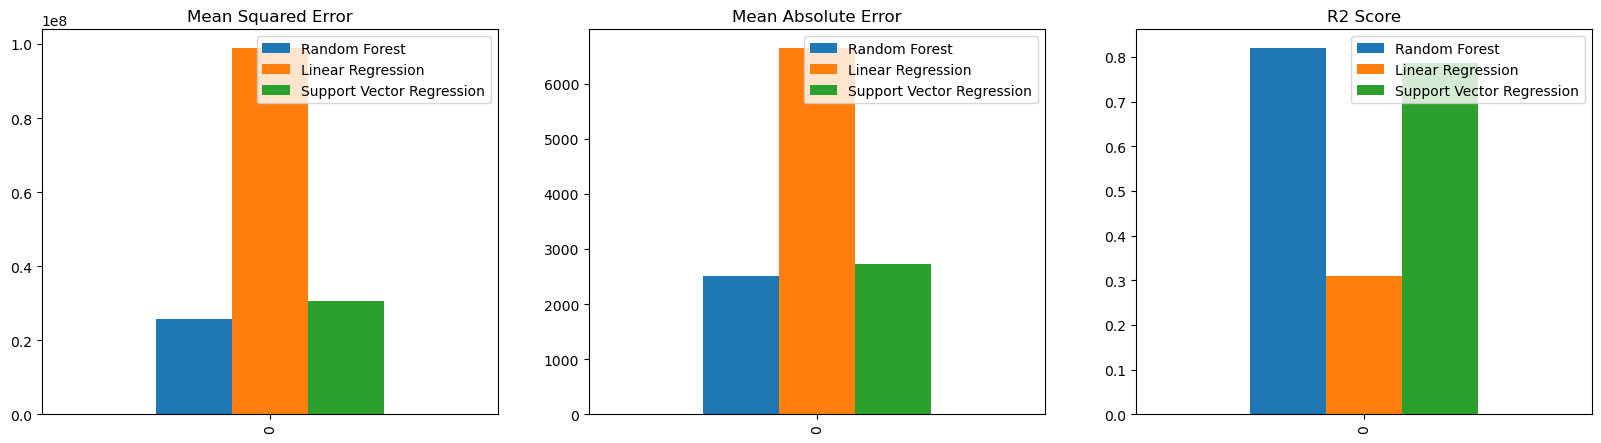

In [83]:
df_mse = pd.DataFrame(
    {'Random Forest': [RF_mse], 'Linear Regression': [LR_mse], 'Support Vector Regression': [SVR_mse]})
df_mae = pd.DataFrame(
    {'Random Forest': [RF_mae], 'Linear Regression': [LR_mae], 'Support Vector Regression': [SVR_mae]})
df_r2 = pd.DataFrame({'Random Forest': [RF_r2], 'Linear Regression': [LR_r2], 'Support Vector Regression': [SVR_r2]})

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

df_mse.plot(kind='bar', ax=ax[0], title='Mean Squared Error')
df_mae.plot(kind='bar', ax=ax[1], title='Mean Absolute Error')
df_r2.plot(kind='bar', ax=ax[2], title='R2 Score')

plt.show()

## Conclusion

After adding the two dimensionality reductions, the results are very similar to the previous result. Random Forest still performs as the best model, with SVM slightly behind. Linear Regression is still performing the worst.

Keynotes:
In R2 score, Random Forest appear to perform slightly better than before with the new dimensionality reduction. 

In MEA Linear Regression performs worse than before the reduction, by ~3,000. Which means with the fewer features it is not able to predict the dependent variable.

In MSE Random Forests performs slightly better than before the reduction. 

# Train and save final model

In [84]:
from sklearn.pipeline import make_pipeline


# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     reduced_RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(reduced_RF_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

In [86]:
import pickle

filename = 'reduced_final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))